In [2]:
%%capture captured_output
%pip install numpy==1.26
%pip install matplotlib==3.9.2
%pip install skillsnetwork
%pip install tensorflow==2.20.0


<div style="text-align: center;">
  <a href="https://cognitiveclass.ai/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0321ENSkillsNetwork951-2022-01-01">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0321EN-SkillsNetwork/image/IDSN-logo.png" width="400">
  </a>
</div>



<h1 align=left><font size = 6>Data Loading and Augmentation Using Keras</font></h1>

<h1 align=left><font size = 5>Building efficient data loaders with Keras</font></h1>


**Estimated time:** 30 minutes


<h2>Learning objective</h2>
After completing this lab, you'll be able to:

- Build and test a custom data generator in Keras for efficient, on-the-fly loading, and preprocessing of image datasets.
- Use Keras’s `image_dataset_from_directory` utility to load and preprocess datasets with optimized performance using the `tf.data` API.
- Apply image augmentation and performance optimizations such as `.map()`, `.cache()`, and `.prefetch()` to build high-throughput data pipelines.
- Compare custom and built-in Keras data loaders in terms of code complexity, flexibility, and runtime efficiency.


## Introduction

In this lab, you'll use two **Keras** functions to build efficient, automated data pipelines: custom data generator and the in-built Keras utility.

1.  **Custom data generator:** You'll write a Python generator function to load, preprocess, and yield batches of data on-the-fly. This will help you understand the working of a production-level data generator.
2.  **In-built Keras utility:** You will use the highly optimized `tf.keras.utils.image_dataset_from_directory` function, which is the standard, production-ready approach for most image classification tasks.

Finally, you will compare these two methods to understand their trade-offs in terms of simplicity, features, and performance.

**Note:** You’ll complete hands-on tasks embedded throughout the lab. These tasks are strategically designed to reinforce key concepts and deepen your understanding.


## Table of contents

<font size = 3> 
    
1. [Configure the setup](#Configure-the-setup)
3. [What is custom data generator?](#What-is-custom-data-generator?)
4. [What is Keras' built-in utility?](#What-is-Keras'-built-in-utility?)
5. [Comparison and analysis](#Comparison-and-analysis)

</font>
    
</div>


### Install required libraries

The following required libraries are not preinstalled in the Skills Network Labs environment. __You must run the following cell__ to install them. The installation might take a few minutes.


In [3]:
%%capture captured_output
%pip install numpy==1.26
%pip install matplotlib==3.9.2
%pip install skillsnetwork
%pip install tensorflow==2.19

#### Check whether the libraries were installed successfully.


In [4]:
output_text = captured_output.stdout
lines = output_text.splitlines()
output_last_10_lines = '\n'.join(lines[-10:])
if "error" in output_last_10_lines.lower():
    print("Library installation failed!")
    print("--- Error Details ---")
    print(output_last_10_lines)
else:
    print("Library installation was successful, let's proceed ahead")

Library installation failed!
--- Error Details ---
Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement tensorflow==2.19 (from versions: 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.19
Note: you may need to restart the kernel to use updated packages.


## Configure the setup

First, install and import the necessary libraries.


In [6]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import skillsnetwork

## Download data
 Download and extract data from the cloud.
 
 Define the data directories.


In [7]:
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/4Z1fwRR295-1O3PMQBH6Dg/images-dataSAT.tar"

extraction_path = "."
await skillsnetwork.prepare(url = url, path = extraction_path, overwrite = True)

  0%|          | 0/6003 [00:00<?, ?it/s]

Saved to '.'


Now, you will be able to see the **images_dataSAT** folder in the left pane. It has two folders  **class_0_non_agri** and **class_1_agri**.
The folder structure looks as follows:

```python
images_dataSAT/
├── class_0_non_agri/
└── class_1_agri/

```

<table>
    <tr>
        <td style="text-align:center;"><b>Primary folder</b></td>
        <td style="text-align:center;"><b>Subfolders</b></td>
    </tr>
    <tr>
        <td><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/owykkC4Pr2zxLtU6vskQ5A/DL0321EN-M1L1-file-tree-Screenshot-1.png" style="width:300px; border:0px solid black;"></td>
        <td><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/okqnadJpvAeedGUXXYBIFg/DL0321EN-M1L1-file-tree-Screenshot-2.png" style="width:350px; border:0px solid black;"></td>
    </tr>
</table>


**class_0_non_agri** is the non-agricultural land class, as defined earlier, and it represents images with non-cultivable land. 

**class_1_agri**, on the other hand, is the agricultural land class, and it represents the images with cultivable land.



<table>
    <tr>
        <td style="text-align:center;"><b>class_0_non_agri</b></td>
        <td style="text-align:center;"><b>class_1_agri</b></td>
    </tr>
    <tr>
        <td><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/1jSl6X5tUkVro8I_av8lEQ/DL0321EN-M1L1-file-tree-screenshot-3.png" style="width:300px; border:1px solid black;"></td>
        <td><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/9f7sT5DBeFE_6Mp2OV3JKQ/DL0321EN-M1L1-file-tree-screenshot-4.png" style="width:300px; border:1px solid black;"></td>
    </tr>
</table>


In [8]:
# Define directories
base_dir = './images_dataSAT/'
# Note: It's common practice for class directories to have clear names.
# Using 'class_0' and 'class_1' is good for automatic inference.
dir_non_agri = os.path.join(base_dir, 'class_0_non_agri')
dir_agri = os.path.join(base_dir, 'class_1_agri')

### **Task 1:** Create the list "**all_image_paths**" containing paths of all files for both folders, *class_0_non_agri* and *class_1_agri*, in the base directory.
For  non_agri images, assign label "0" and assign label "1" for each image in the agri folder.



In [9]:
## You can use this cell to type the code to answer the question.

# Initialize empty lists to store paths and labels
all_image_paths = []
all_labels = []

# define the labels for each class
label_non_agri = 0
label_agri = 1

# populate the lists

for fname in os.listdir(dir_non_agri):
    all_image_paths.append(os.path.join(dir_non_agri, fname))
    all_labels.append(label_non_agri)

for fname in os.listdir(dir_agri):
    all_image_paths.append(os.path.join(dir_agri, fname))
    all_labels.append(label_agri)


Double-click **here** for the solution.
<!-- The correct answer is:

# Initialize empty lists to store paths and labels
all_image_paths = []
all_labels = []

# define the labels for each class
label_non_agri = 0
label_agri = 1

# populate the lists

for fname in os.listdir(dir_non_agri):
    all_image_paths.append(os.path.join(dir_non_agri, fname))
    all_labels.append(label_non_agri)

for fname in os.listdir(dir_agri):
    all_image_paths.append(os.path.join(dir_agri, fname))
    all_labels.append(label_agri)

-->


### **Task 2:** Create a temporary list "**temp**" by binding the image paths and labels using the `zip` function. 
Then, randomly select and print 5 image paths and their corresponding labels.


In [10]:
## You can use this cell to type the code to answer the question.

temp = list(zip(all_image_paths, all_labels))
np.random.shuffle(temp)
all_image_paths, all_labels = zip(*temp)

print("First 5 paths and labels (after shuffling):", list(zip(all_image_paths[:5], all_labels[:5])))

First 5 paths and labels (after shuffling): [('./images_dataSAT/class_1_agri/tile_S2A_MSIL2A_20250409T105701_N0511_R094_T31UDQ_20250409T173716.SAFE_8038.jpg', 1), ('./images_dataSAT/class_0_non_agri/tile_S2A_MSIL2A_20250427T101701_N0511_R065_T32UPE_20250427T170513.SAFE_5352.jpg', 0), ('./images_dataSAT/class_0_non_agri/tile_S2A_MSIL2A_20250427T101701_N0511_R065_T32UPE_20250427T170513.SAFE_9114.jpg', 0), ('./images_dataSAT/class_1_agri/tile_S2A_MSIL2A_20250427T101701_N0511_R065_T32UPE_20250427T170513.SAFE_11776.jpg', 1), ('./images_dataSAT/class_0_non_agri/tile_S2A_MSIL2A_20250427T101701_N0511_R065_T32UPE_20250427T170513.SAFE_6902.jpg', 0)]


Double-click **here** for the solution.
<!--
# Use zip to bind paths and labels, then shuffle this list of pairs
temp = list(zip(all_image_paths, all_labels))
np.random.shuffle(temp)
all_image_paths, all_labels = zip(*temp)

print("First 5 paths and labels (after shuffling):", list(zip(all_image_paths[:5], all_labels[:5])))

-->


## What is custom data generator?

A custom data generator function uses the `yield` keyword. Unlike a regular function that returns once and terminates, a generator can yield multiple values, pausing its state between each call. This "lazy evaluation" is the core principle behind memory-efficient sequential loading. For deep learning, this means we can create a generator that provides one batch of data, waits for the model to train on it, and then resumes to provide the next batch, all without loading the entire dataset into RAM.


### Create the generator function

The `custom_data_generator` function builds an infinite Python generator that supplies mini-batches of images and labels to a Keras model during training. It accepts four arguments: `image_paths`, a list of file locations; `labels`, the corresponding class IDs; `batch_size`, the number of samples per update; and `target_size`, a tuple dictating each image’s resize dimensions. 

At the start of every epoch, in the code you create an index array equal to the dataset length, **shuffle it with NumPy**, and reorder both paths and labels identically, preserving their pairing while randomizing order. The outer `while True` loop keeps the generator alive for successive epochs. Inside, a `for` loop walks through the shuffled dataset in `batch_size` steps, slicing out `batch_paths` and `batch_labels`. For each path, `tf.keras.utils.load_img` reads the image and rescales it to `target_size`; `img_to_array` converts the PIL image to a float32 NumPy array. These arrays accumulate in `batch_images`. 

After the inner loop finishes, the batch is transformed into a NumPy array and divided by 255.0, scaling pixel values from 0–255 to 0–1, which speeds convergence and stabilizes gradients. Finally, the generator yields a tuple (`batch_images`, `batch_labels`). It supports easy augmentation and custom preprocessing.



In [11]:
def custom_data_generator(image_paths, labels, batch_size, target_size=(64, 64)):
    """A custom data generator to feed a Keras model."""
    num_samples = len(image_paths)
    while True: 
        # Shuffle data at the beginning of each epoch
        indices = np.arange(num_samples)
        np.random.shuffle(indices)
        shuffled_paths = np.array(image_paths)[indices]
        shuffled_labels = np.array(labels)[indices]
        
        # Generate batch data
        for offset in range(0, num_samples, batch_size):
            batch_paths = shuffled_paths[offset:offset+batch_size]
            batch_labels = shuffled_labels[offset:offset+batch_size]
            
            # Load and preprocess images from the batch
            batch_images = []
            for path in batch_paths:
                img = tf.keras.utils.load_img(path, target_size=target_size)
                img_array = tf.keras.utils.img_to_array(img)
                batch_images.append(img_array)
            
            # Normalize and yield the batch data
            yield np.array(batch_images) / 255.0, np.array(batch_labels)

### Test and visualize the custom generator
Before feeding a generator to a model, it is essential to test it. 
First you instantiate `custom_data_generator` using `image_paths`, `labels` and `batch_size`, deifning the key dataloading hyperparameters.

Next you use `next(my_generator)`to get a batch of data. By calling `next(my_generator)`, you are asking the generator to execute its code until it hits the `yield` statement and to return the yielded values. This allows us to inspect a single batch to verify its shape, data types, and content. Visualizing the images with their corresponding labels, using tools like `matplotlib.pyplot.imshow`, provides a sanity check to ensure that the loading, preprocessing, and labeling logic is correct.
You can display the images in two rows and 4 columns using `ax = plt.subplot(2, 4, i + 1)` code.  This ensures optimal use of resources for displaying a sample batch of images with their labels.


### **Task 3:** Obtain a batch of data, using batch size 8 and the `custom_data_generator` function. 
Print the batch shape for the image and label the data obtained.
Display the images and corresponding labels using `matplotlib.pyplot` library for visual inspection.


Images batch shape: (8, 64, 64, 3)
Labels batch shape: (8,)


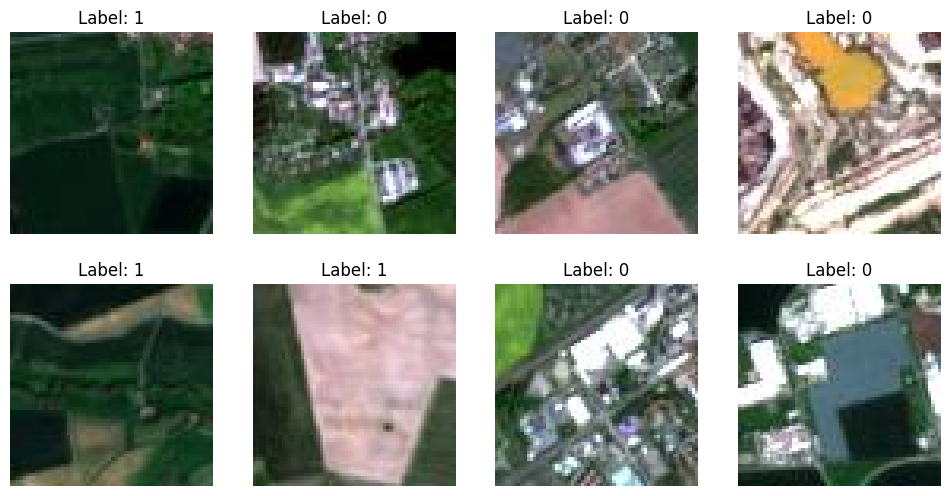

In [12]:
## You can use this cell to type the code to answer the question.

batch_size = 8
data_generator = custom_data_generator(image_paths=all_image_paths, labels=all_labels, batch_size=batch_size)

# Get one batch data
images, labels = next(data_generator)

# Print batch data statistics
print(f"Images batch shape: {images.shape}")
print(f"Labels batch shape: {labels.shape}")

# Display the images in the batch
plt.figure(figsize=(12, 6))
for i in range(batch_size):
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(images[i])
    plt.title(f"Label: {int(labels[i])}")
    plt.axis("off")


Double-click **here** for the solution.
<!--
batch_size = 8
data_generator = custom_data_generator(image_paths=all_image_paths, 
                                       labels=all_labels, 
                                       batch_size=batch_size)
 
# Get one batch data
images, labels = next(data_generator)
 
# Print batch data statistics
print(f"Images batch shape: {images.shape}")
print(f"Labels batch shape: {labels.shape}")
 
# Display the images in the batch
plt.figure(figsize=(12, 6))
for i in range(batch_size):
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(images[i])
    plt.title(f"Label: {int(labels[i])}")
    plt.axis("off")

-->


## What is Keras' built-in utility?
Now, instead of using a custom written data generator function, let's see how the `tf.keras.utils.image_dataset_from_directory` function works. This function is built on top of the highly efficient `tf.data` library, which is TensorFlow's native solution for creating complex and performant input pipelines. This function automatically infers class labels from a standardized directory structure (e.g., `main_dir/class_a/`, `main_dir/class_b/`) and returns a `tf.data.Dataset` object. This object is extremely memory efficient and gives the symbolic representation of a data stream, which can be manipulated and optimized for maximum performance.


### Create the training data 
Use the `tf.keras.utils.image_dataset_from_directory` function with image size **64 x 64** pixels and a batch size **8**.


In [13]:
IMAGE_SIZE = (64, 64)
BATCH_SIZE = 8

# Create a training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    labels='inferred',          # Labels are generated from directory structure
    label_mode='int',           # Labels are encoded as integers (0, 1, ...)
    validation_split=0.2,       # Reserve 20% of images for validation
    subset='training',          # This is the training set
    seed=1337,                  # Shuffle seed for reproducible splits
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

Found 6000 files belonging to 2 classes.
Using 4800 files for training.


### **Task 4:** Create validation data using batch size 8. 
The validation data is created by using the `subset` keyword in the `tf.keras.utils.image_dataset_from_directory` method.


In [14]:
## You can use this cell to type the code to answer the question

val_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    labels='inferred',
    label_mode='int',
    validation_split=0.2,
    subset='validation',
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)


Found 6000 files belonging to 2 classes.
Using 1200 files for validation.


Double-click **here** for the solution.
<!--
# Create a validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    labels='inferred',
    label_mode='int',
    validation_split=0.2,
    subset='validation',
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

-->


### Explore the `tf.data.Dataset` object
The `tf.data.Dataset` object is a core component of TensorFlow's data input pipeline. It represents a sequence of elements, where each element is a tuple of (images, labels). It is designed for high-throughput, parallel processing. The `.take(1)` method is used here to fetch a single element (one batch) from this data stream for inspection. Unlike our custom generator, which loaded images as NumPy arrays, this utility loads them as TensorFlow Tensors, which is the native data type for TensorFlow operations.


Class names inferred by Keras: ['class_0_non_agri', 'class_1_agri']


2025-09-20 14:37:04.698810: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


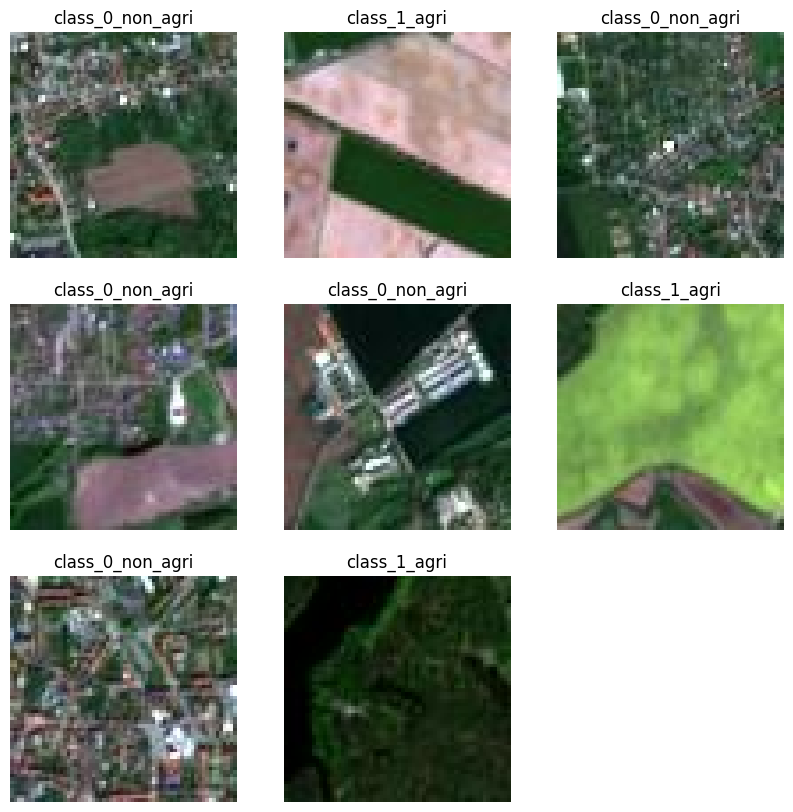

In [16]:
print(f"Class names inferred by Keras: {train_ds.class_names}")

# Let's visualize one batch from the training dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):  # Take one batch
    for i in range(BATCH_SIZE):
        ax = plt.subplot(3, 3, i + 1)
        # Images are loaded as float32, so we convert to uint8 for display
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")

### Configure the dataset for performance

The dedicated utility, `tf.data.Dataset`, can be chained with various methods to create a highly performant pipeline. 
- **`.map(function)`:** Applies a given function to every element of the dataset. Here, it is used to apply data augmentation layers. TensorFlow can automatically parallelize this operation.
- **`.cache()`:** Caches the dataset in memory after it's loaded from disk during the first epoch. For subsequent epochs, data will be read from the faster memory cache, significantly speeding up training. This is **only feasible if** the dataset fits in RAM.
- **`.prefetch(buffer_size)`:** It allows the data preprocessing (done on the CPU) to happen in parallel with the model training (done on the GPU). While the GPU is busy with the current batch, the CPU is already preparing the next batch. This overlapping of tasks prevents the GPU from sitting idle and waiting for data, a phenomenon known as an I/O bottleneck.
- **`AUTOTUNE`** lets TensorFlow dynamically decide the optimal buffer size for your computer.


In [17]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

# Apply augmentation to the training dataset using map
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# Configure for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

print("Dataset is now configured for high performance!")

Dataset is now configured for high performance!


## Comparison and analysis

We've now seen two ways to create a data loader in Keras. This comparison highlights the engineering trade-offs between control and convenience.


| Feature                  | Custom data generator                                       | In-built Keras utility (`image_dataset_from_directory`)     |
|--------------------------|-------------------------------------------------------------|-------------------------------------------------------------|
| **Ease of use**          | Low. Requires significant boilerplate code for loops, shuffling, and batching. | High. A single, intuitive function call handles everything. |
| **Code complexity**      | High. You manually manage file paths, labels, loading, and preprocessing. | Low. The function abstracts away all the complexity.          |
| **Flexibility**          | Very high. You can implement any custom logic for loading or non-standard data structures. | Moderate. Designed for a standard directory structure (`class/images`), but very flexible within that. |
| **Features**             | Basic. Shuffling, augmentation, and validation splits must be coded manually. | Rich. Built-in shuffling, batching, and validation splits. Seamless integration with Keras preprocessing layers. |
| **Performance**          | Poor to moderate. A simple Python generator can become an I/O bottleneck for the GPU due to its single-threaded nature. | Excellent. Creates a `tf.data.Dataset` object, which is highly optimized and can be configured with `.cache()` and `.prefetch()` for maximum throughput. |
| **Recommended for**      | Learning purposes or highly specialized, non-standard datasets (e.g., loading from a database or a custom binary format). | **Almost all standard image classification tasks.**         |


## Save and download the notebook for **final project** submission and evaluation

You will need to save and download the completed notebook for final project submission and evaluation. 
<br>For saving and downloading the completed ntoebook, please follow the steps given below:</br>

<font size = 4>  

1) **Complete** all the tasks and questions given in the notebook.

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/nv4jHlPU5_R1q7ZJrZ69eg/DL0321EN-M1L1-Save-IPYNB-Screenshot-1.png" style="width:600px; border:0px solid black;">

2) **Save** the notebook.</style>
<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/9-WPWD4mW1d-RV5Il5otTg/DL0321EN-M1L1-Save-IPYNB-Screenshot-2.png" style="width:600px; border:0px solid black;">

3) Identify and right click on the **correct notebook file** in the left pane.</style>
<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/RUSRPw7NT6Sof94B7-9naQ/DL0321EN-M1L1-Save-IPYNB-Screenshot-3.png" style="width:600px; border:0px solid black;">

4) Click on **Download**.</style>
<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/HHry4GT-vhLEcRi1T_LHGg/DL0321EN-M1L1-Save-IPYNB-Screenshot-4.png" style="width:600px; border:0px solid black;">

5) Download and **Save** the Jupyter notebook file on your computer **for final submission**.</style>
<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/hhsJbxc6R-T8_pXQGjMjvg/DL0321EN-M1L1-Save-IPYNB-Screenshot-5.png" style="width:600px; border:0px solid black;">
  </font>


### Summary

In this lab, you built a custom data generator as an exercise to understand the principles of on-the-fly data processing. You tested the Keras in-built utilities, which are the preferred choice for real-world projects over custom-written data generators.

You learned that the `tf.keras.utils.image_dataset_from_directory` function provides a simple and more performant solution. Leveraging the power of `tf.data` ensures your data pipeline can keep up with modern hardware, preventing data loading from becoming a bottleneck during model training.


### Thank you for completing this lab!

You are now equipped with the standard, production-ready method for loading image data in Keras!
This notebook is part of a course on **Coursera** called *AI Capstone Project with Deep Learning*.


<!-- Change log
## Change log

|  Date (YYYY-MM-DD) |  Version | Changed By  |  Change Description |
|---|---|---|---|
| 2025-06-16  | 1.0  | Aman  |  Created the lab |

--!>


<h2>Author</h2>

[Aman Aggarwal](https://www.linkedin.com/in/aggarwal-aman)

Aman Aggarwal is a PhD working at the intersection of neuroscience, AI, and drug discovery. He specializes in quantitative microscopy and image processing.



<!-- This is a comment in HTML ## Change log

|  Date (YYYY-MM-DD) |  Version | Changed By  |  Change Description |
|---|---|---|---|
| 2025-06-11  | 1.0  | Aman  |  Created the lab |
| 2025-06-30  | 2.0  | Gagandeeep |  ID review |
-->


© Copyright IBM Corporation. All rights reserved.
